In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [2]:
# === Cell 0 — Quickstart & discovery (mentor monolith only) ==================
import os, glob, json

EVAL_SIGMA = 0.10
N_EVAL_WINDOWS = 20

def _looks_like_monolith_json(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            J = json.load(f)
        P = J.get("parameters", {})
        return isinstance(P, dict) and any(k in P for k in ("full_params","weights","params","theta"))
    except Exception:
        return False

def _discover_monolith(base_dir=".", pattern="runs_full_qae_*"):
    base_abs = os.path.abspath(base_dir)
    roots = [d for d in glob.glob(os.path.join(base_abs, pattern)) if os.path.isdir(d)]
    models, skipped = {}, 0
    for r in roots:
        for p in glob.glob(os.path.join(r, "**", "*.json"), recursive=True):
            if not _looks_like_monolith_json(p):
                skipped += 1
                continue
            tag = os.path.splitext(os.path.basename(p))[0]
            k = tag; i = 1
            while k in models:
                i += 1; k = f"{tag}_{i}"
            models[k] = os.path.abspath(p)
    return roots, models, skipped

DISCOVERED_ROOTS, MODEL_PATHS, SKIPPED = _discover_monolith(".")

print(f"Discovery roots (under jacobs_examples only): {len(DISCOVERED_ROOTS)}")
for r in DISCOVERED_ROOTS: print("  •", r)
print(f"Monolith models registered: {len(MODEL_PATHS)} (skipped other JSONs: {SKIPPED})")
for name, path in list(MODEL_PATHS.items())[:6]:
    print(f"  ✓ {name:<28s} <- {path}")

Discovery roots (under jacobs_examples only): 4
  • /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_3LT1
  • /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_2LT4
  • /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_2LT2
  • /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_4LT2
Monolith models registered: 40 (skipped other JSONs: 0)
  ✓ 4q_3l_1t_3ls_03              <- /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_3LT1/q4_l3t1/L3/4q_3l_1t_3ls_03.json
  ✓ 4q_3l_1t_3ls_04              <- /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_3LT1/q4_l3t1/L3/4q_3l_1t_3ls_04.json
  ✓ 4q_3l_1t_3ls_05              <- /home/

In [3]:
# === Cell 1 — Imports & utilities ===========================================
import os, re, json, math, time, hashlib, warnings
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.6, 4.2)

# ---- scaling / angles ----
def values_to_v01(v, low, high):
    v = np.asarray(v, dtype=float)
    # return (v - low) / max(1e-12, (high - low))
    return v

def v01_to_values(v01, low, high):
    v01 = np.asarray(v01, dtype=float)
    # return low + v01 * (high - low)
    return v01

def readoutZ_to_values(z, low, high):
    z = np.clip(np.asarray(z, dtype=float), -0.999999, 0.999999)
    # v01 = np.arccos(z) / np.pi
    v01 = z
    return v01_to_values(v01, low, high)

def values_to_RY_angles(v, low, high):
    # return np.pi * values_to_v01(v, low, high)
    return values_to_v01(v, low, high)

# ---- deterministic noise ----
def _stable_seed(tag: str) -> int:
    h = hashlib.sha256(tag.encode("utf-8")).digest()
    return int.from_bytes(h[:8], "little") & 0x7FFFFFFF

def add_gaussian_noise_series(series, sigma, low, high, seed):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, sigma * (high - low), size=series.shape)
    return np.clip(series + noise, low, high)

# ---- stats ----
def bootstrap_ci_mean(x, B=3000, alpha=0.05, rng=None):
    x = np.asarray(x, dtype=float)
    if x.size == 0: return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(None if rng is None else rng)
    n = x.size
    xb = np.empty(B, float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        xb[b] = np.mean(x[idx])
    xb.sort()
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test_pvalue(diffs):
    diffs = np.asarray(diffs, dtype=float)
    wins  = int(np.sum(diffs > 0))
    losses= int(np.sum(diffs < 0))
    n     = wins + losses
    if n == 0: return 1.0
    tail = sum(math.comb(n, k) for k in range(0, min(wins, losses)+1)) / (2**n)
    return float(min(1.0, 2*tail))

In [4]:
# === Cell 2 — Deterministic MG datasets (W=4 & W=6) ==========================
NOISE_GRID = (EVAL_SIGMA,)

def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float); x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]; xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

def scale_to_range(y, low=0.2, high=0.8):
    y = np.asarray(y, dtype=float)
    ymin, ymax = float(y.min()), float(y.max())
    if ymax - ymin < 1e-12:
        return np.full_like(y, (low+high)/2), (low, high)
    z = (y - ymin) / (ymax - ymin)
    return low + z * (high - low), (low, high)

def make_windows(ts, size, step):
    ts = np.asarray(ts, dtype=float)
    return np.array([ts[i:i+size] for i in range(0, len(ts)-size+1, step)], dtype=float)

@dataclass
class Dataset:
    name: str
    clean: np.ndarray
    scale_low: float
    scale_high: float
    windows_clean: np.ndarray
    split_idx: int
    noisy_series_by_sigma: dict
    noisy_windows_by_sigma: dict

def _build_for_window_size(window_size=4, window_step=1, noise_grid=NOISE_GRID):
    mgA = mackey_glass(length=1300, tau=17)
    mgB = mackey_glass(length=1300, tau=30)
    sA,(loA,hiA) = scale_to_range(mgA, 0.2, 0.8)
    sB,(loB,hiB) = scale_to_range(mgB, 0.2, 0.8)
    winA = make_windows(sA, window_size, window_step)
    winB = make_windows(sB, window_size, window_step)
    splitA = int(0.75 * len(winA)); splitB = int(0.75 * len(winB))

    def make_maps(name, scaled, lo, hi):
        series_map, win_map = {}, {}
        for sigma in noise_grid:
            seed = _stable_seed(f"{name}|sigma={sigma:.3f}|W={window_size}|v1")
            noisy = add_gaussian_noise_series(scaled, sigma, lo, hi, seed)
            series_map[round(sigma,3)] = noisy
            win_map[round(sigma,3)] = make_windows(noisy, window_size, window_step)
        return series_map, win_map

    nsA_s, nsA_w = make_maps("MG_A", sA, loA, hiA)
    nsB_s, nsB_w = make_maps("MG_B", sB, loB, hiB)

    return {
        "MG_A": Dataset("MG_A", sA, loA, hiA, winA, splitA, nsA_s, nsA_w),
        "MG_B": Dataset("MG_B", sB, loB, hiB, winB, splitB, nsB_s, nsB_w),
    }

WINDOW_STEP = 1
DATASETS_BY_W = {
    4: _build_for_window_size(4, WINDOW_STEP, NOISE_GRID),
    6: _build_for_window_size(6, WINDOW_STEP, NOISE_GRID),
}
print("Datasets ready for window sizes:", list(DATASETS_BY_W))

Datasets ready for window sizes: [4, 6]


In [5]:
# === Cell 3 - Monolith QAE================
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp

def values_to_v01(v, low, high):
    v = np.asarray(v, dtype=float)
    # return (v - low) / max(1e-12, (high - low))
    return v
    
# def values_to_RY_angles(v, low, high): return np.pi * values_to_v01(v, low, high)
def values_to_RY_angles(v, low, high):
    return values_to_v01(v, low, high)
    
def readoutZ_to_values(z, low, high):
    z = np.clip(np.asarray(z, dtype=float), -0.999999, 0.999999)
    # v01 = np.arccos(z) / np.pi
    # return low + v01 * (high - low)
    return z

class MonolithQAE:
    def __init__(self, *, n_qubits, n_layers, n_latent, n_trash,
                 scale_low, scale_high, full_params, rot="Rxyz"):
        self.n_qubits = int(n_qubits)
        self.n_layers = int(n_layers)
        self.n_latent = int(n_latent)
        self.n_trash  = int(n_trash)
        self.scale_low  = float(scale_low)
        self.scale_high = float(scale_high)
        self.rot = str(rot)  # we’ll still infer from param length below if needed

        # wires
        self.latent_wires = list(range(self.n_latent))
        self.trash_wires  = list(range(self.n_latent, self.n_latent + self.n_trash))
        self.data_wires   = self.latent_wires + self.trash_wires
        self.anz_wires    = self.data_wires  # no extras in our runs

        # split params into [encoder | decoder] HALVES (this matches training!)
        fp = np.asarray(full_params, dtype=float).ravel()
        # try Rxyz split
        need_rxyz = 2 * self.n_layers * self.n_qubits * 3
        need_ry   = 2 * self.n_layers * self.n_qubits
        if fp.size == need_rxyz:
            self.rot = "Rxyz"
            half = fp.size // 2
            enc = fp[:half].reshape(self.n_layers, self.n_qubits, 3)
            dec = fp[half:].reshape(self.n_layers, self.n_qubits, 3)
        elif fp.size == need_ry:
            self.rot = "Ry"
            half = fp.size // 2
            enc = fp[:half].reshape(self.n_layers, self.n_qubits)
            dec = fp[half:].reshape(self.n_layers, self.n_qubits)
        else:
            raise ValueError(f"Param length {fp.size} not equal to 2*L*Q*(3 or 1). "
                             f"L={self.n_layers}, Q={self.n_qubits}")

        self.enc_weights = pnp.asarray(enc, requires_grad=False)
        self.dec_weights = pnp.asarray(dec, requires_grad=False)

        self.dev = qml.device("default.qubit", wires=self.n_qubits, shots=None)
        self._q_fwd = self._q_lat = self._q_tr = None

    # --- building blocks (identical to mentor training) ---
    def _sequence_encoder(self, wires, angles):
        # angles already in radians
        n = len(angles)
        for w in wires:
            th = float(angles[w]) if w < n else 0.0
            qml.RY(th, wires=w)

    def _entangler(self, weights):
        if self.rot == "Ry":
            qml.BasicEntanglerLayers(weights, wires=self.anz_wires, rotation=qml.RY)
        else:
            qml.StronglyEntanglingLayers(weights, wires=self.anz_wires)

    def _encoder_block(self, enc_w):
        self._entangler(enc_w)

    def _decoder_block(self, dec_w):
        # IMPORTANT: adjoint of the *decoder* block weights (second half),
        # exactly like training (not shared with encoder).
        qml.adjoint(self._entangler)(dec_w)

    def _embed_from_values(self, values_window):
        self._sequence_encoder(self.data_wires,
                               values_to_RY_angles(values_window, self.scale_low, self.scale_high))

    # --- QNodes (no grads needed) ---
    def _build_forward(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed_from_values(values_window)
            self._encoder_block(self.enc_weights)
            # reset trash
            for w in self.trash_wires:
                qml.measure(w, reset=True)
            # decoder = adjoint(dec-block)
            self._decoder_block(self.dec_weights)
            # no output de-encoder
            return [qml.expval(qml.PauliZ(w)) for w in self.data_wires]
        return qnode

    def _build_latents_after_encoder(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed_from_values(values_window)
            self._encoder_block(self.enc_weights)
            return [qml.expval(qml.PauliZ(w)) for w in self.latent_wires]
        return qnode

    def _build_trash_probs_after_encoder(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed_from_values(values_window)
            self._encoder_block(self.enc_weights)
            return qml.probs(wires=self.trash_wires)
        return qnode

    # public API
    def forward_expZ(self, values_window):
        if self._q_fwd is None: self._q_fwd = self._build_forward()
        return np.asarray(self._q_fwd(values_window), dtype=float)

    def latents_after_encoder_expZ(self, values_window):
        if self._q_lat is None: self._q_lat = self._build_latents_after_encoder()
        return np.asarray(self._q_lat(values_window), dtype=float)

    def trash_probs_after_encoder(self, values_window):
        if self._q_tr is None: self._q_tr = self._build_trash_probs_after_encoder()
        return np.asarray(self._q_tr(values_window), dtype=float)

    def map_expZ_to_values(self, z_all):
        return readoutZ_to_values(z_all, self.scale_low, self.scale_high)

    def predict_values(self, values_window):
        return self.map_expZ_to_values(self.forward_expZ(values_window))

    def describe(self):
        print(f"Mentor Monolith QAE — nq={self.n_qubits}, L={self.n_layers}, "
              f"latent={self.n_latent}, trash={self.n_trash}, rot={self.rot}, "
              f"decoder=adjoint(dec-block), scale=[{self.scale_low},{self.scale_high}]")

In [6]:
# === Cell 4 — Loader for monolith JSON bundles ========================
# Expected:
# {
#   "dataset": {"scale_low":..., "scale_high":..., "window_size": nq, "window_stride": ...},
#   "architecture": {"n_qubits":..., "n_layers":..., "n_latent":..., "n_trash":..., "decoder_mode": "..."},
#   "run": {"sigma_train": ...},
#   "parameters": {"full_params": [...]}
# }

import os, re, json
import numpy as np
from dataclasses import dataclass

_STD_RE = re.compile(r"(?P<nq>\d+)q_(?P<nl>\d+)l_(?P<nt>\d+)t_(?P<L>\d+)ls_(?P<inst>\d+)\.json$", re.IGNORECASE)
def parse_std_filename(path):
    m=_STD_RE.search(os.path.basename(path))
    if not m: return {}
    d={k:int(v) for k,v in m.groupdict().items()}
    return {"n_qubits":d["nq"], "n_latent":d["nl"], "n_trash":d["nt"], "n_layers":d["L"], "instance":d["inst"]}

def parse_model_json_monolith(path, default_rot="Rxyz"):
    with open(path, "r", encoding="utf-8") as f:
        J = json.load(f)

    P = J.get("parameters", {})
    full_params = None
    for key in ("full_params","weights","params","theta"):
        if key in P and isinstance(P[key], (list,tuple)):
            full_params = np.asarray(P[key], dtype=float).ravel()
            break
    if full_params is None:
        raise ValueError(f"{os.path.basename(path)}: no parameters.full_params-like array found")

    arch = J.get("architecture", {})
    ds   = J.get("dataset", {})
    run  = J.get("run", {})

    fn = parse_std_filename(path)
    n_qubits = int(arch.get("n_qubits", ds.get("window_size", fn.get("n_qubits", 4))))
    n_layers = int(arch.get("n_layers", fn.get("n_layers", 1)))
    n_latent = int(arch.get("n_latent", fn.get("n_latent", max(1, n_qubits//2))))
    n_trash  = int(arch.get("n_trash",  fn.get("n_trash", n_qubits - n_latent)))
    rot      = str(arch.get("rot", default_rot))

    scale_low  = float(ds.get("scale_low", 0.2))
    scale_high = float(ds.get("scale_high", 0.8))
    sigma_train = float(run.get("sigma_train", np.nan))

    info = dict(n_qubits=n_qubits, n_layers=n_layers, n_latent=n_latent, n_trash=n_trash,
                scale_low=scale_low, scale_high=scale_high, rot=rot, sigma_train=sigma_train,
                filename=os.path.basename(path))
    return {"full_params": full_params, "info": info}

@dataclass
class ModelEntry:
    name: str
    path: str
    n_qubits: int
    n_latent: int
    n_trash: int
    scale_low: float
    scale_high: float
    noise_sigma_train: float
    meta: dict
    impl: object

def instantiate_model_monolith(parsed):
    i = parsed["info"]
    return MonolithQAE(
        n_qubits=i["n_qubits"], n_layers=i["n_layers"],
        n_latent=i["n_latent"], n_trash=i["n_trash"],
        scale_low=i["scale_low"], scale_high=i["scale_high"],
        full_params=parsed["full_params"], rot=i["rot"]
    )

def load_models_monolith(model_paths: dict):
    reg={}
    for name, path in model_paths.items():
        try:
            P = parse_model_json_monolith(path)
            impl = instantiate_model_monolith(P)
            i = P["info"]
            reg[name] = ModelEntry(
                name=name, path=path, n_qubits=i["n_qubits"], n_latent=i["n_latent"], n_trash=i["n_trash"],
                scale_low=i["scale_low"], scale_high=i["scale_high"],
                noise_sigma_train=i["sigma_train"], meta=i, impl=impl
            )
            print(f"✓ Loaded {name:<22s} file={i['filename']}  "
                  f"(nq={i['n_qubits']}, L={i['n_layers']}, latent={i['n_latent']}, "
                  f"trash={i['n_trash']}, rot={i['rot']})")
            impl.describe()
        except Exception as e:
            print(f"✗ {name}: {e}")
    return reg

In [7]:
# === Cell 5 — Evaluation core (metrics we need) ==============================
from dataclasses import dataclass

@dataclass
class EvalResult:
    noisy_mse: np.ndarray
    model_mse: np.ndarray
    delta_pct: np.ndarray
    delta_pct_sym: np.ndarray
    recon_values: np.ndarray
    noisy_values: np.ndarray
    clean_values: np.ndarray
    # --- extras for monolith diagnostics ---
    lat_clean: np.ndarray | None = None
    lat_noisy: np.ndarray | None = None
    p00_trash: np.ndarray | None = None

def eval_model_on_dataset(entry, ds, n_eval=20, sigma_override=EVAL_SIGMA):
    s_key = float(np.round(float(sigma_override), 3))
    if s_key not in ds.noisy_windows_by_sigma:
        available = ", ".join([f"{k:.3f}" for k in sorted(ds.noisy_windows_by_sigma)])
        raise ValueError(f"{ds.name}: σ={s_key:.3f} not in [{available}]")
    cleanW = ds.windows_clean[ds.split_idx:]
    noisyW = ds.noisy_windows_by_sigma[s_key][ds.split_idx:]
    N = min(int(n_eval), len(cleanW))
    cleanW = cleanW[:N]; noisyW = noisyW[:N]

    impl = entry.impl
    recon, nmse, dmse, d_pct, d_sym = [], [], [], [], []
    lat_c, lat_n, p00 = [], [], []

    for w_clean, w_noisy in zip(cleanW, noisyW):
        z = impl.forward_expZ(w_noisy)
        y = impl.map_expZ_to_values(z)
        recon.append(y)

        mse_n = float(np.mean((w_clean - w_noisy)**2))
        mse_d = float(np.mean((w_clean - y     )**2))
        nmse.append(mse_n); dmse.append(mse_d)
        d_pct.append(0.0 if mse_n<1e-12 else 100.0*(mse_n - mse_d)/mse_n)
        d_sym.append(200.0*(mse_n - mse_d)/max(mse_n + mse_d, 1e-12))

        # diagnostics (guarded)
        try:
            lc = impl.latents_after_encoder_expZ(w_clean)
            ln = impl.latents_after_encoder_expZ(w_noisy)
            lat_c.append(lc); lat_n.append(ln)
        except Exception:
            lat_c = lat_n = None
        try:
            P = impl.trash_probs_after_encoder(w_noisy)  # length = 2^(n_trash)
            p00.append(float(P[0]))  # |00..0> probability
        except Exception:
            p00 = None

    return EvalResult(
        noisy_mse=np.asarray(nmse), model_mse=np.asarray(dmse),
        delta_pct=np.asarray(d_pct), delta_pct_sym=np.asarray(d_sym),
        recon_values=np.asarray(recon), noisy_values=noisyW, clean_values=cleanW,
        lat_clean=None if lat_c is None else np.asarray(lat_c),
        lat_noisy=None if lat_n is None else np.asarray(lat_n),
        p00_trash=None if p00 is None else np.asarray(p00),
    )

def summarize_eval(er: EvalResult):
    mean_imp, lo_imp, hi_imp = bootstrap_ci_mean(er.delta_pct)
    mean_sym, lo_sym, hi_sym = bootstrap_ci_mean(er.delta_pct_sym)
    p_val = sign_test_pvalue(er.noisy_mse - er.model_mse)
    succ  = 100.0 * float(np.mean(er.delta_pct > 0))
    return {
        "noisy_MSE_mean": float(np.mean(er.noisy_mse)),
        "model_MSE_mean": float(np.mean(er.model_mse)),
        "delta_pct_mean": float(mean_imp),
        "delta_pct_CI95": [float(lo_imp), float(hi_imp)],
        "delta_pct_sym_mean": float(mean_sym),
        "delta_pct_sym_CI95": [float(lo_sym), float(hi_sym)],
        "sign_test_p": float(p_val),
        "success_rate_pct": float(succ),
        "n_windows": int(er.noisy_mse.size)
    }

In [8]:
# === Cell 6 — Run benchmark (window-size aware) ==============================
REG = load_models_monolith(MODEL_PATHS)

def run_benchmark(model_registry, n_eval=N_EVAL_WINDOWS, sigma_override=EVAL_SIGMA):
    all_results, all_summaries = {}, {}
    for name, entry in model_registry.items():
        w = int(entry.n_qubits)
        if w not in DATASETS_BY_W:
            warnings.warn(f"No dataset for window_size={w}; skipping {name}."); continue
        for dsname, ds in DATASETS_BY_W[w].items():
            er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma_override=sigma_override)
            sm = summarize_eval(er)
            all_results.setdefault(dsname, {})[name]  = er
            all_summaries.setdefault(dsname, {})[name]= sm
            print(f"{dsname} | {name:24s} Δ%={sm['delta_pct_mean']:+5.1f} "
                  f"(CI {sm['delta_pct_CI95'][0]:+.1f},{sm['delta_pct_CI95'][1]:+.1f})  "
                  f"succ={sm['success_rate_pct']:4.1f}%  p={sm['sign_test_p']:.4f}")
    return all_results, all_summaries

ALL_RESULTS, ALL_SUMMARIES = run_benchmark(REG, n_eval=N_EVAL_WINDOWS, sigma_override=EVAL_SIGMA)

# quick table
if ALL_SUMMARIES:
    rows=[]
    for dsname, d in ALL_SUMMARIES.items():
        for name, sm in d.items():
            e = REG[name]
            rows.append({
                "dataset": dsname, "model": name,
                "n_qubits": e.n_qubits, "n_latent": e.n_latent, "n_trash": e.n_trash,
                "layers": e.meta.get("n_layers", None),
                "delta_pct_mean": sm["delta_pct_mean"],
                "delta_pct_lo": sm["delta_pct_CI95"][0],
                "delta_pct_hi": sm["delta_pct_CI95"][1],
                "success_rate_pct": sm["success_rate_pct"],
                "p": sm["sign_test_p"],
            })
    df = pd.DataFrame(rows).sort_values(["dataset","n_qubits","layers","model"])
    print("\n== Summary (head) =="); print(df.head(12).to_string(index=False))

✓ Loaded 4q_3l_1t_3ls_03        file=4q_3l_1t_3ls_03.json  (nq=4, L=3, latent=3, trash=1, rot=Rxyz)
Mentor Monolith QAE — nq=4, L=3, latent=3, trash=1, rot=Rxyz, decoder=adjoint(dec-block), scale=[0.2,0.8]
✓ Loaded 4q_3l_1t_3ls_04        file=4q_3l_1t_3ls_04.json  (nq=4, L=3, latent=3, trash=1, rot=Rxyz)
Mentor Monolith QAE — nq=4, L=3, latent=3, trash=1, rot=Rxyz, decoder=adjoint(dec-block), scale=[0.2,0.8]
✓ Loaded 4q_3l_1t_3ls_05        file=4q_3l_1t_3ls_05.json  (nq=4, L=3, latent=3, trash=1, rot=Rxyz)
Mentor Monolith QAE — nq=4, L=3, latent=3, trash=1, rot=Rxyz, decoder=adjoint(dec-block), scale=[0.2,0.8]
✓ Loaded 4q_3l_1t_3ls_01        file=4q_3l_1t_3ls_01.json  (nq=4, L=3, latent=3, trash=1, rot=Rxyz)
Mentor Monolith QAE — nq=4, L=3, latent=3, trash=1, rot=Rxyz, decoder=adjoint(dec-block), scale=[0.2,0.8]
✓ Loaded 4q_3l_1t_3ls_02        file=4q_3l_1t_3ls_02.json  (nq=4, L=3, latent=3, trash=1, rot=Rxyz)
Mentor Monolith QAE — nq=4, L=3, latent=3, trash=1, rot=Rxyz, decoder=adjoin

In [9]:
# === Cell 7 — Merge eval columns into your training CSVs =====================
import os, glob

# Find a common root to search CSVs
if DISCOVERED_ROOTS:
    try:
        JACOB_ROOT = os.path.commonpath([os.path.dirname(r) for r in DISCOVERED_ROOTS])
    except ValueError:
        JACOB_ROOT = os.path.dirname(DISCOVERED_ROOTS[0])
else:
    JACOB_ROOT = os.path.abspath(".")

def find_many(root, pattern):
    return sorted(glob.glob(os.path.join(root, "**", pattern), recursive=True))

# Build a long eval frame keyed by filename (your saver writes that)
def _eval_long_df(all_summaries, registry):
    rows=[]
    for dsname, bymodel in all_summaries.items():
        for name, sm in bymodel.items():
            e = registry[name]
            rows.append({
                "filename": os.path.basename(e.path),
                "model": name,
                "dataset": dsname,
                "n_qubits": e.n_qubits,
                "n_layers": e.meta.get("n_layers", None),
                "n_latent": e.n_latent,
                "n_trash": e.n_trash,
                "delta_pct_mean": sm["delta_pct_mean"],
                "success_rate_pct": sm["success_rate_pct"],
                "sign_test_p": sm["sign_test_p"],
                "n_windows": sm["n_windows"],
            })
    return pd.DataFrame(rows)

eval_long = _eval_long_df(ALL_SUMMARIES, REG)
if eval_long.empty:
    raise RuntimeError("No eval summaries collected. Did models load & run?")

# pivot to columns per dataset
pivot = eval_long.pivot_table(index="filename", columns="dataset",
                              values=["delta_pct_mean","success_rate_pct","sign_test_p"],
                              aggfunc="first")
pivot.columns = [f"{a}_{b}" for a,b in pivot.columns.to_flat_index()]
pivot = pivot.reset_index()

# add AVG columns
for base in ["delta_pct_mean","success_rate_pct","sign_test_p"]:
    cols = [c for c in pivot.columns if c.startswith(base+"_")]
    if cols:
        pivot[f"{base}_AVG"] = pivot[cols].mean(axis=1, skipna=True)

# locate CSVs
train_csvs  = find_many(JACOB_ROOT, "all_training_instances_*.csv")
layer_csvs  = find_many(JACOB_ROOT, "summary_by_layers_*.csv")
print(f"\nFound {len(train_csvs)} training-instance CSV(s) and {len(layer_csvs)} layer-summary CSV(s).")

# merge into every training CSV (write *_with_eval.csv)
train_outputs = []
for csv_in in train_csvs:
    try:
        df = pd.read_csv(csv_in, low_memory=False)
        if "filename" not in df.columns:
            print(f"  ! Skipping (no 'filename' column): {csv_in}")
            continue
        merged = df.merge(pivot, on="filename", how="left")
        # coerce new numeric columns
        for c in merged.columns:
            if any(c.startswith(k) for k in ["delta_pct_mean_","success_rate_pct_","sign_test_p_"]) or c.endswith("_AVG"):
                merged[c] = pd.to_numeric(merged[c], errors="coerce")
        csv_out = csv_in.replace(".csv", "_with_eval.csv")
        merged.to_csv(csv_out, index=False)
        train_outputs.append(csv_out)
        print(f"  ✓ Wrote training+eval → {csv_out}")
    except Exception as e:
        print(f"  ✗ {csv_in}: {e}")

# Build layer-level aggregates (fallback from eval_long if needed)
def _mean_std_str(s):
    v = pd.to_numeric(s, errors="coerce").astype(float)
    v = v[np.isfinite(v)]
    return "n/a" if v.size == 0 else f"{v.mean():.6f} ± {v.std(ddof=0):.6f}"

def build_layer_eval_from_eval_long(eval_long_df):
    info = (eval_long_df[["filename","n_layers"]]
            .drop_duplicates()
            .set_index("filename"))
    wide = eval_long_df.pivot_table(index="filename",
                                    columns="dataset",
                                    values=["delta_pct_mean","success_rate_pct","sign_test_p"],
                                    aggfunc="first")
    wide.columns = [f"{a}_{b}" for a,b in wide.columns.to_flat_index()]
    wide = wide.reset_index().merge(info, on="filename", how="left")
    def grp_stat(s): return _mean_std_str(s)
    layer_eval = (wide.groupby("n_layers", dropna=False)
                       .apply(lambda t: pd.Series({
                           "delta_MG_A": grp_stat(t.get("delta_pct_mean_MG_A")),
                           "delta_MG_B": grp_stat(t.get("delta_pct_mean_MG_B")),
                           "succ_MG_A":  grp_stat(t.get("success_rate_pct_MG_A")),
                           "succ_MG_B":  grp_stat(t.get("success_rate_pct_MG_B")),
                           "p50_MG_A":   f"{pd.to_numeric(t.get('sign_test_p_MG_A'), errors='coerce').median():.6f}",
                           "p50_MG_B":   f"{pd.to_numeric(t.get('sign_test_p_MG_B'), errors='coerce').median():.6f}",
                       }))
                       .reset_index())
    return layer_eval

layer_outputs = []
layer_eval_fallback = build_layer_eval_from_eval_long(eval_long)
for csv_in in layer_csvs:
    try:
        layer_df = pd.read_csv(csv_in)
        if "n_layers" not in layer_df.columns and layer_df.index.name == "n_layers":
            layer_df = layer_df.reset_index()
        merged_layer = layer_df.merge(layer_eval_fallback, on="n_layers", how="left")
        csv_out = csv_in.replace(".csv", "_with_eval.csv")
        merged_layer.to_csv(csv_out, index=False)
        layer_outputs.append(csv_out)
        print(f"  ✓ Wrote layer+eval → {csv_out}")
    except Exception as e:
        print(f"  ✗ {csv_in}: {e}")


Found 16 training-instance CSV(s) and 16 layer-summary CSV(s).
  ✓ Wrote training+eval → /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_2LT2/all_training_instances_v3_with_eval.csv
  ✓ Wrote training+eval → /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_2LT2/all_training_instances_v3_with_eval_with_eval.csv
  ✓ Wrote training+eval → /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_2LT2/all_training_instances_v3_with_eval_with_eval_with_eval.csv
  ✗ /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/jacobs_examples/runs_full_qae_2LT2/all_training_instances_v3_with_eval_with_eval_with_eval.csv: Passing 'suffixes' which cause duplicate columns {'success_rate_pct_MG_A_x', 'delta_pct_mean_AVG_x', 'delta_pct_mean_MG_A_x', 'success_rate_pct_AVG_x', 'delta_pct_mean_MG_B_x'

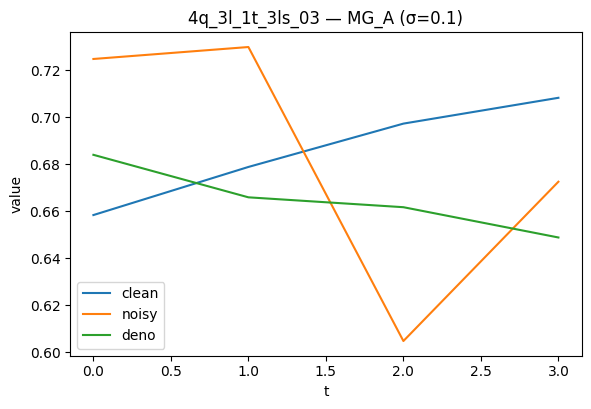

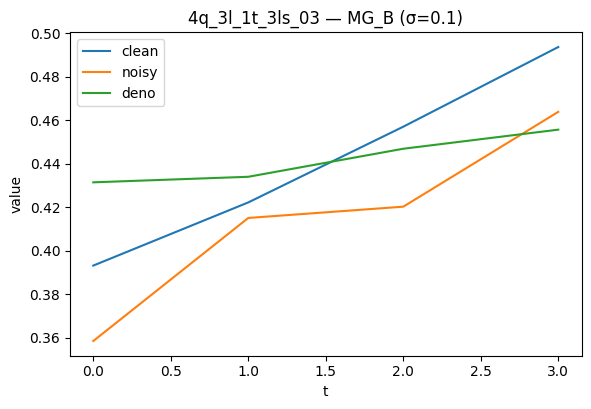

In [10]:
# === Cell 8 — Minimal visuals (optional) =====================================
if REG:
    # pick the first loaded model and show one example per matching dataset
    name0, entry0 = next(iter(REG.items()))
    w0 = entry0.n_qubits
    dsA = DATASETS_BY_W[w0]["MG_A"]; dsB = DATASETS_BY_W[w0]["MG_B"]
    def plot_example(er, title):
        c,n,d = er.clean_values[0], er.noisy_values[0], er.recon_values[0]
        xs = np.arange(len(c))
        plt.figure(); plt.plot(xs,c,label="clean"); plt.plot(xs,n,label="noisy"); plt.plot(xs,d,label="deno")
        plt.title(title); plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.show()
    erA = eval_model_on_dataset(entry0, dsA, n_eval=N_EVAL_WINDOWS, sigma_override=EVAL_SIGMA)
    erB = eval_model_on_dataset(entry0, dsB, n_eval=N_EVAL_WINDOWS, sigma_override=EVAL_SIGMA)
    plot_example(erA, f"{name0} — MG_A (σ={EVAL_SIGMA:g})")
    plot_example(erB, f"{name0} — MG_B (σ={EVAL_SIGMA:g})")

In [11]:
# === Cell 9 — Plotting & extra analytics (monolith) ==========================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_reconstruction_example(er, idx=0, title="Reconstruction"):
    c, n, d = er.clean_values[idx], er.noisy_values[idx], er.recon_values[idx]
    xs = np.arange(len(c))
    plt.figure()
    plt.plot(xs, c, label="clean")
    plt.plot(xs, n, label="noisy")
    plt.plot(xs, d, label="denoised")
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("value")
    plt.legend()
    plt.show()

def plot_delta_distributions(er_by_model, title="ΔMSE% (per-window)"):
    plt.figure()
    for name, er in er_by_model.items():
        plt.hist(er.delta_pct, bins=12, alpha=0.5, label=name)
    plt.title(title)
    plt.xlabel("improvement %")
    plt.ylabel("count")
    plt.legend()
    plt.show()

def plot_robustness(entry, ds, sigmas=(0.10,), n_eval=N_EVAL_WINDOWS):
    means, lows, highs, xs = [], [], [], []
    avail = set(ds.noisy_windows_by_sigma.keys())
    for s in sigmas:
        s_key = float(np.round(float(s), 3))
        if s_key not in avail:
            print(f"[robustness] skip σ={s_key:.3f} (available: {sorted(avail)})")
            continue
        er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma_override=s_key)
        m, lo, hi = bootstrap_ci_mean(er.delta_pct)
        xs.append(float(s_key)); means.append(m); lows.append(lo); highs.append(hi)
    if not xs:
        return
    plt.figure()
    plt.plot(xs, means, marker="o")
    plt.fill_between(xs, lows, highs, alpha=0.2)
    plt.xlabel("σ")
    plt.ylabel("ΔMSE% (mean, 95% CI)")
    plt.title(f"Robustness on {ds.name} — {entry.name}")
    plt.show()

def plot_latent_trash(er, entry, dsname):
    if getattr(er, "lat_clean", None) is not None and getattr(er, "lat_noisy", None) is not None:
        diffs = np.mean((er.lat_clean - er.lat_noisy)**2, axis=1)
        plt.figure()
        plt.hist(diffs, bins=12)
        plt.title(f"Latent drift MSE — {entry.name} on {dsname}")
        plt.xlabel("MSE")
        plt.ylabel("count")
        plt.show()
    if getattr(er, "p00_trash", None) is not None:
        plt.figure()
        plt.hist(er.p00_trash, bins=12)
        plt.title(f"Trash P(|00⟩) after encoder — {entry.name} on {dsname}")
        plt.xlabel("P00")
        plt.ylabel("count")
        plt.show()

# Tables & heatmaps
def summaries_to_df(all_summaries, registry):
    rows = []
    for dsname, bymodel in all_summaries.items():
        for name, sm in bymodel.items():
            e = registry[name]
            rows.append({
                "dataset": dsname,
                "model": name,
                "n_qubits": e.n_qubits,
                "n_latent": e.n_latent,
                "n_trash": e.n_trash,
                "layers": e.meta.get("n_layers", getattr(e.impl, "n_layers", None)),
                "delta_pct_mean": sm["delta_pct_mean"],
                "delta_pct_lo": sm["delta_pct_CI95"][0],
                "delta_pct_hi": sm["delta_pct_CI95"][1],
                "success_rate_pct": sm["success_rate_pct"],
                "p": sm["sign_test_p"],
            })
    return pd.DataFrame(rows)

def heatmap_by_arch(df, dataset, value_col="delta_pct_mean"):
    sub = df[df["dataset"] == dataset]
    for (nl, nt), group in sub.groupby(["n_latent", "n_trash"]):
        piv = group.pivot_table(index="n_qubits", columns="layers", values=value_col, aggfunc="mean")
        if piv.size == 0:
            continue
        plt.figure(figsize=(5.2, 3.6))
        plt.imshow(piv.values, aspect="auto")
        plt.xticks(range(piv.shape[1]), piv.columns)
        plt.yticks(range(piv.shape[0]), piv.index)
        plt.colorbar(label=value_col)
        plt.title(f"{dataset} — mean {value_col} (latent={nl}, trash={nt})")
        plt.xlabel("layers")
        plt.ylabel("n_qubits")
        plt.tight_layout()
        plt.show()

# Full-series tools
def _flatten_avg(windows, step):
    N, W = windows.shape
    L = (N - 1) * step + W
    acc = np.zeros(L)
    cnt = np.zeros(L)
    for i in range(N):
        s = i * step
        e = s + W
        acc[s:e] += windows[i]
        cnt[s:e] += 1
    return acc / np.maximum(cnt, 1e-12)

def reconstruct_full_series(entry, ds, sigma_override=EVAL_SIGMA, step=1):
    s_key = float(np.round(float(sigma_override), 3))
    if s_key not in ds.noisy_windows_by_sigma:
        avail = ", ".join([f"{k:.3f}" for k in sorted(ds.noisy_windows_by_sigma)])
        raise ValueError(f"{ds.name}: σ={s_key:.3f} not in [{avail}]")
    cleanW = np.asarray(ds.windows_clean, dtype=float)
    noisyW = np.asarray(ds.noisy_windows_by_sigma[s_key], dtype=float)
    preds = [entry.impl.map_expZ_to_values(entry.impl.forward_expZ(w)) for w in noisyW]
    preds = np.asarray(preds)
    flat_c = _flatten_avg(cleanW, step)
    flat_n = _flatten_avg(noisyW, step)
    flat_d = _flatten_avg(preds, step)
    mse_n = float(np.mean((flat_c - flat_n)**2))
    mse_d = float(np.mean((flat_c - flat_d)**2))
    d_pct = 0.0 if mse_n < 1e-12 else 100.0 * (mse_n - mse_d) / mse_n
    return {
        "clean": flat_c,
        "noisy": flat_n,
        "deno": flat_d,
        "mse_noisy": mse_n,
        "mse_deno": mse_d,
        "delta_pct": d_pct,
        "sigma": s_key,
    }

def plot_full_series(rec, title):
    L = len(rec["clean"])
    xs = np.arange(L)
    plt.figure(figsize=(9.8, 4.0))
    plt.plot(xs, rec["clean"], label="clean")
    plt.plot(xs, rec["noisy"], label=f"noisy (MSE={rec['mse_noisy']:.5f})")
    plt.plot(xs, rec["deno"],  label=f"deno (MSE={rec['mse_deno']:.5f}, Δ%={rec['delta_pct']:+.1f})")
    plt.xlabel("t")
    plt.ylabel("value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_full_series_panels(entry, ds, sigma_override=EVAL_SIGMA,
                            panel_len=180, ncols=3, nrows=2, start=0, sharey=True):
    rec = reconstruct_full_series(entry, ds, sigma_override)
    c, n, d = rec["clean"], rec["noisy"], rec["deno"]
    L = len(c)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 2.75*nrows), sharey=sharey)
    axes = np.ravel(axes)
    for k, ax in enumerate(axes):
        s = start + k * panel_len
        e = min(s + panel_len, L)
        if s >= L:
            ax.axis("off")
            continue
        xs = np.arange(s, e)
        cc, nn, dd = c[s:e], n[s:e], d[s:e]
        mse_n = float(np.mean((cc - nn)**2))
        mse_d = float(np.mean((cc - dd)**2))
        d_pct = 0.0 if mse_n < 1e-12 else 100.0 * (mse_n - mse_d) / mse_n
        ax.plot(xs, cc, label="clean")
        ax.plot(xs, nn, label=f"noisy (MSE={mse_n:.5f})")
        ax.plot(xs, dd, label=f"deno (MSE={mse_d:.5f}, Δ%={d_pct:+.1f})")
        if k == 0:
            ax.legend()
            ax.set_ylabel("value")
        ax.set_title(f"{s}–{e}")
        ax.set_xlabel("t")
    fig.suptitle(f"{entry.name} — {ds.name} (σ={rec['sigma']:.3f}), panels of {panel_len}", y=1.02)
    plt.tight_layout()
    plt.show()

def error_lens(entry, ds, sigma_override=EVAL_SIGMA, seg=150, start=0, length=None):
    rec = reconstruct_full_series(entry, ds, sigma_override)
    c, n, d = rec["clean"], rec["noisy"], rec["deno"]
    L = len(c)
    if length is None:
        length = L - start
    s, e = int(start), int(min(start + length, L))
    se_n = (n - c)**2
    se_d = (d - c)**2
    imp = se_n - se_d
    mean_n = float(se_n.mean())
    mean_d = float(se_d.mean())
    d_pct = 100.0 * (mean_n - mean_d) / max(mean_n, 1e-12)
    frac = 100.0 * float(np.mean(imp > 0))
    print(f"{ds.name} | {entry.name} | σ={rec['sigma']:.3f}\n"
          f"Global MSE: noisy={mean_n:.5f} deno={mean_d:.5f} Δ%={d_pct:+.1f}\n"
          f"Samples improved: {frac:.1f}%")
    xs = np.arange(s, e)
    plt.figure(figsize=(10, 3.1))
    plt.plot(xs, se_n[s:e], label="(clean-noisy)^2")
    plt.plot(xs, se_d[s:e], label="(clean-deno)^2")
    plt.title(f"Per-sample squared errors — {ds.name} [{s}:{e}]")
    plt.xlabel("t")
    plt.ylabel("squared error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2.5))
    imp_seg = imp[s:e]
    plt.plot(xs, imp_seg, lw=0.8)
    plt.fill_between(xs, 0, imp_seg, where=(imp_seg >= 0), alpha=0.35)
    plt.fill_between(xs, 0, imp_seg, where=(imp_seg < 0), alpha=0.25)
    plt.axhline(0, color="k", lw=0.8)
    plt.title(f"Improvement per sample — {ds.name} [{s}:{e}]")
    plt.xlabel("t")
    plt.ylabel("ΔSE")
    plt.tight_layout()
    plt.show()

    bins = list(range(0, L, seg))
    contrib = [imp[i:i+seg].sum() for i in bins]
    centers = [i + seg/2 for i in bins]
    plt.figure(figsize=(10, 3.0))
    plt.bar(centers, contrib, width=0.8*seg)
    plt.axhline(0, color="k", lw=0.8)
    plt.title(f"Contribution to total improvement by {seg}-sample segments — {ds.name}")
    plt.xlabel("segment center")
    plt.ylabel("Σ ΔSE")
    plt.tight_layout()
    plt.show()


== Summary (head) ==
dataset           model  n_qubits  n_latent  n_trash  layers  delta_pct_mean  delta_pct_lo  delta_pct_hi  success_rate_pct        p
   MG_A 4q_3l_1t_3ls_03         4         3        1       3       43.149900     23.725689     61.698040              80.0 0.011818
   MG_A 4q_3l_1t_3ls_04         4         3        1       3       51.616459     36.818472     66.388371              90.0 0.000402
   MG_A 4q_3l_1t_3ls_05         4         3        1       3       13.053445    -18.331020     43.811495              60.0 0.503445
   MG_A 4q_3l_1t_3ls_01         4         3        1       3        6.712060    -19.129940     31.747258              55.0 0.823803
   MG_A 4q_3l_1t_3ls_02         4         3        1       3       48.132223     34.508208     61.164366              95.0 0.000040
   MG_A 4q_3l_1t_1ls_04         4         3        1       1       -9.855049    -55.475759     24.362515              60.0 0.503445
   MG_A 4q_3l_1t_1ls_03         4         3        1  

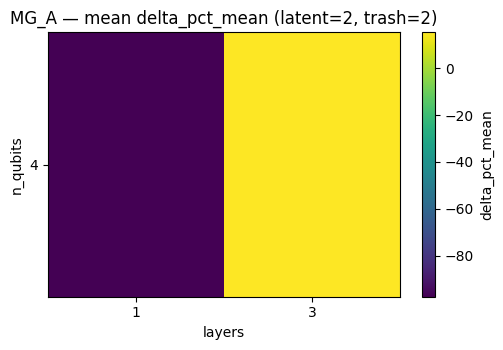

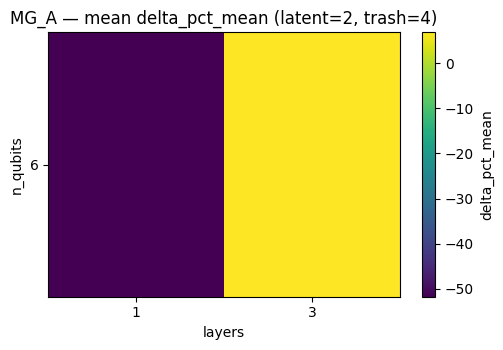

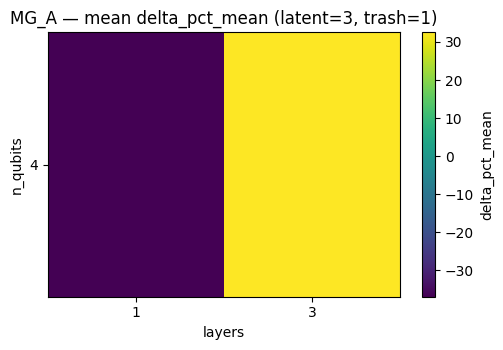

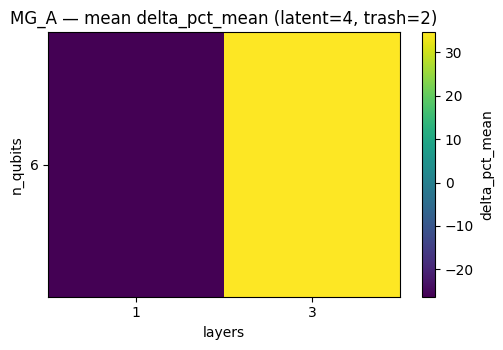

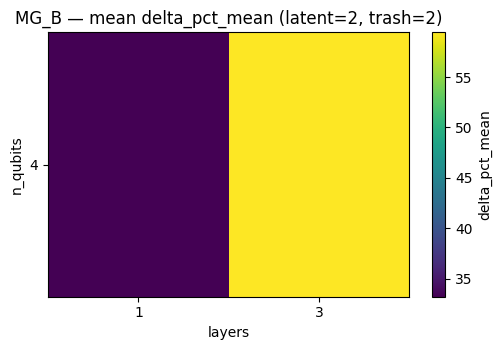

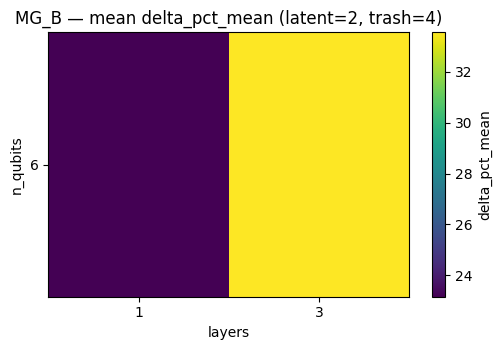

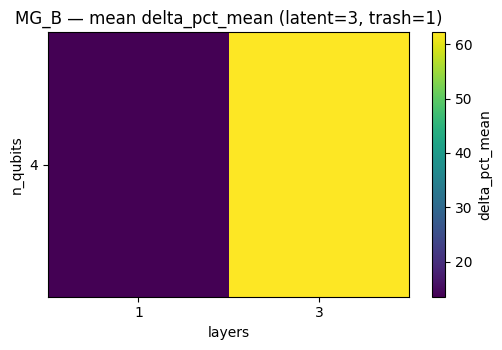

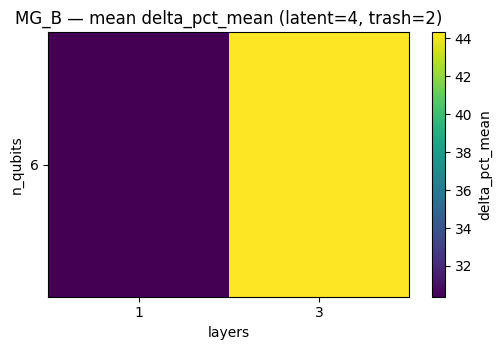

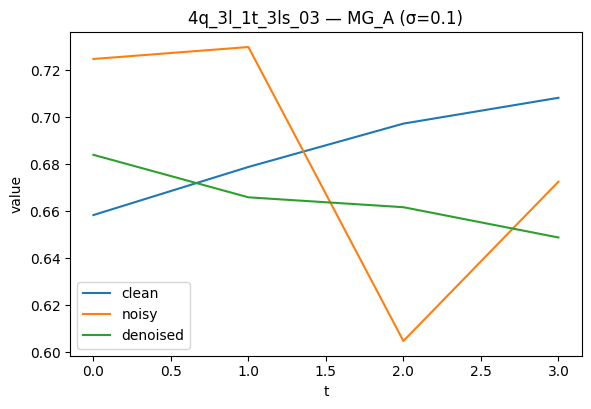

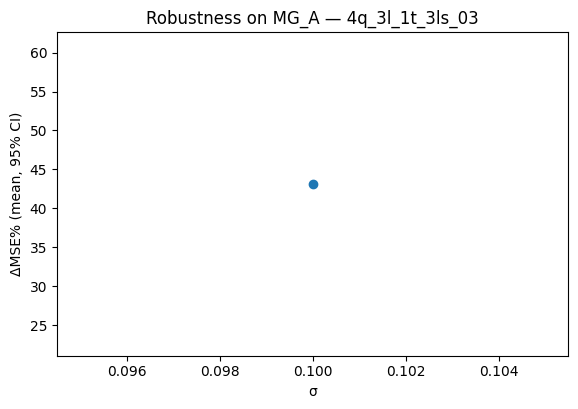

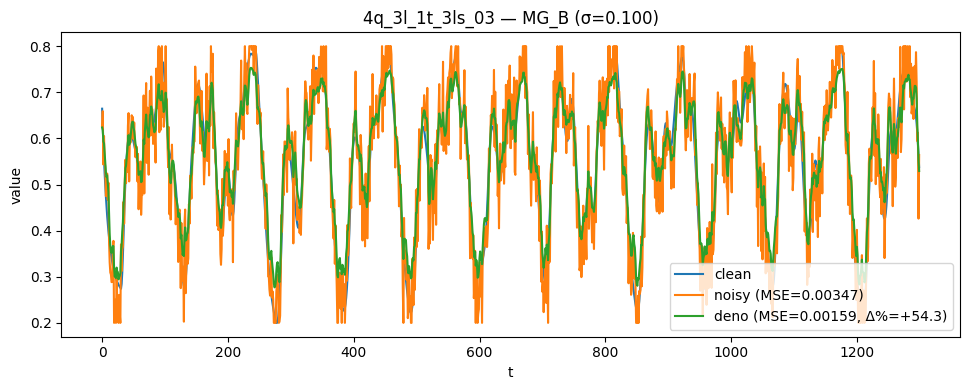

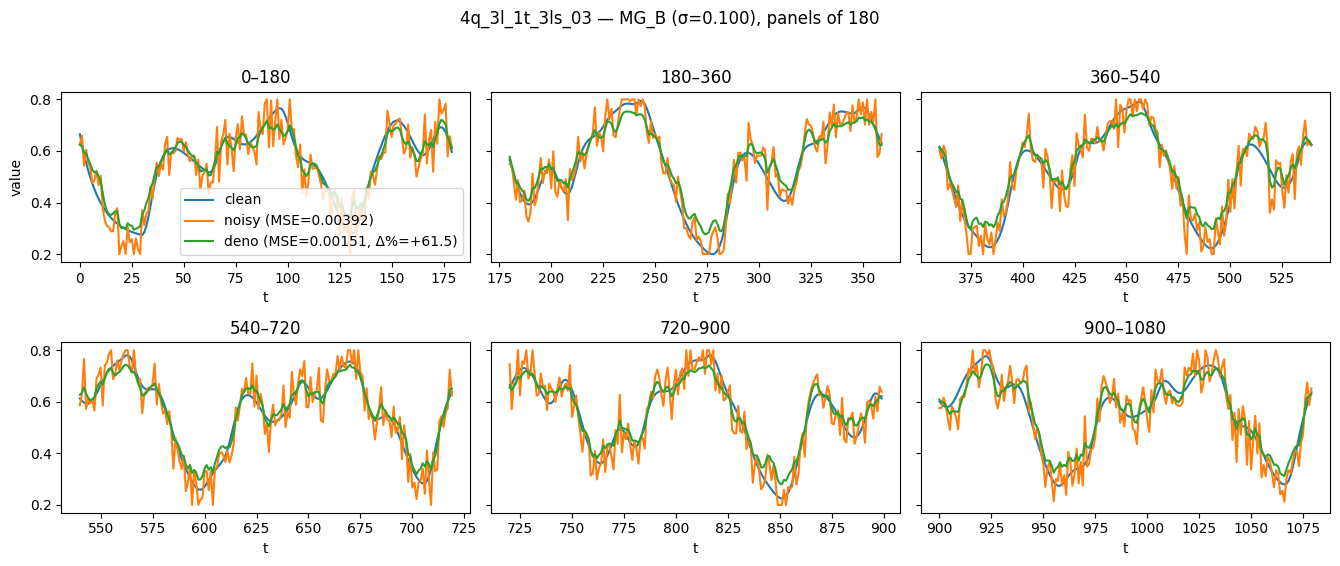

MG_B | 4q_3l_1t_3ls_03 | σ=0.100
Global MSE: noisy=0.00347 deno=0.00159 Δ%=+54.3
Samples improved: 64.9%


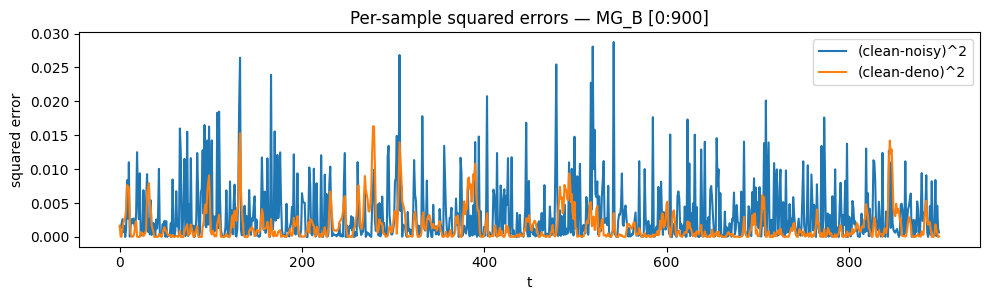

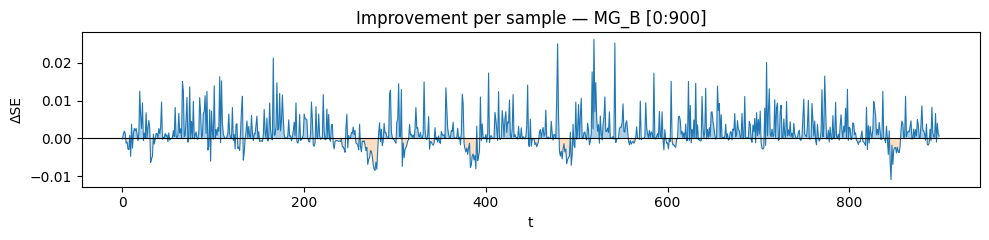

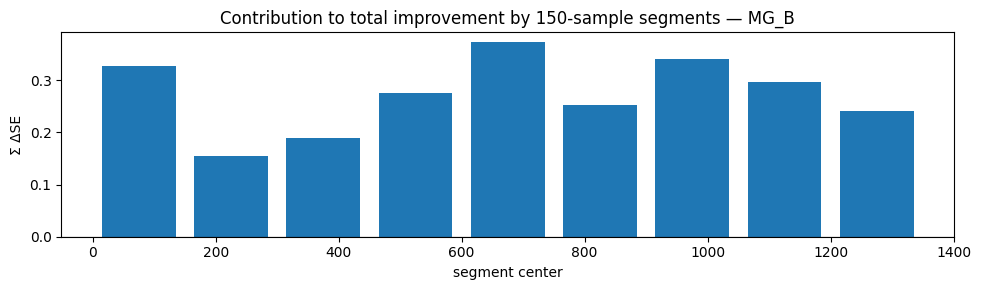

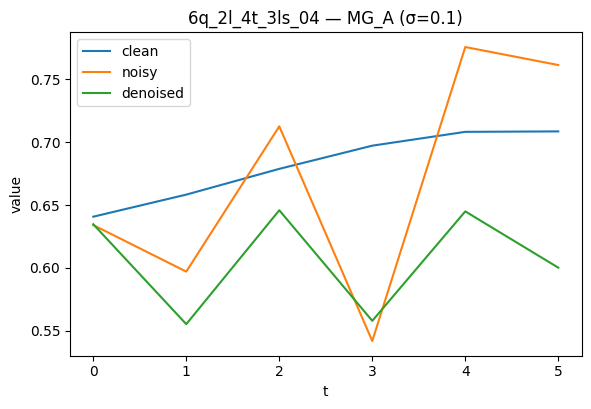

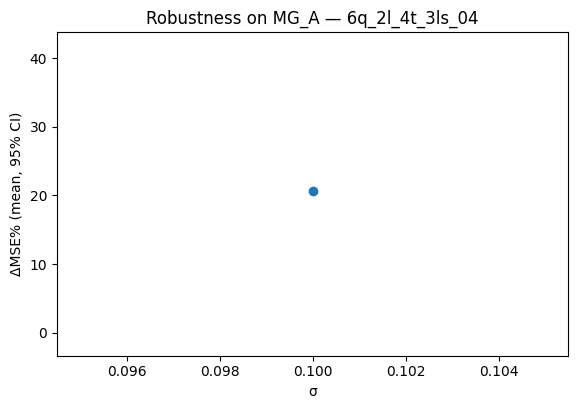

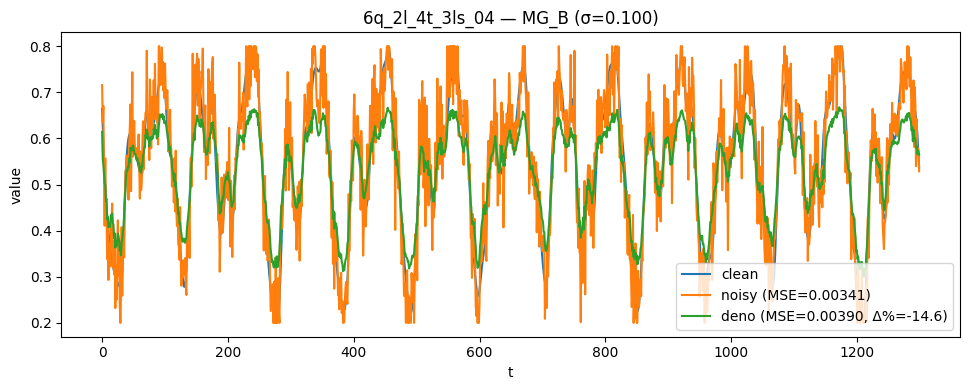

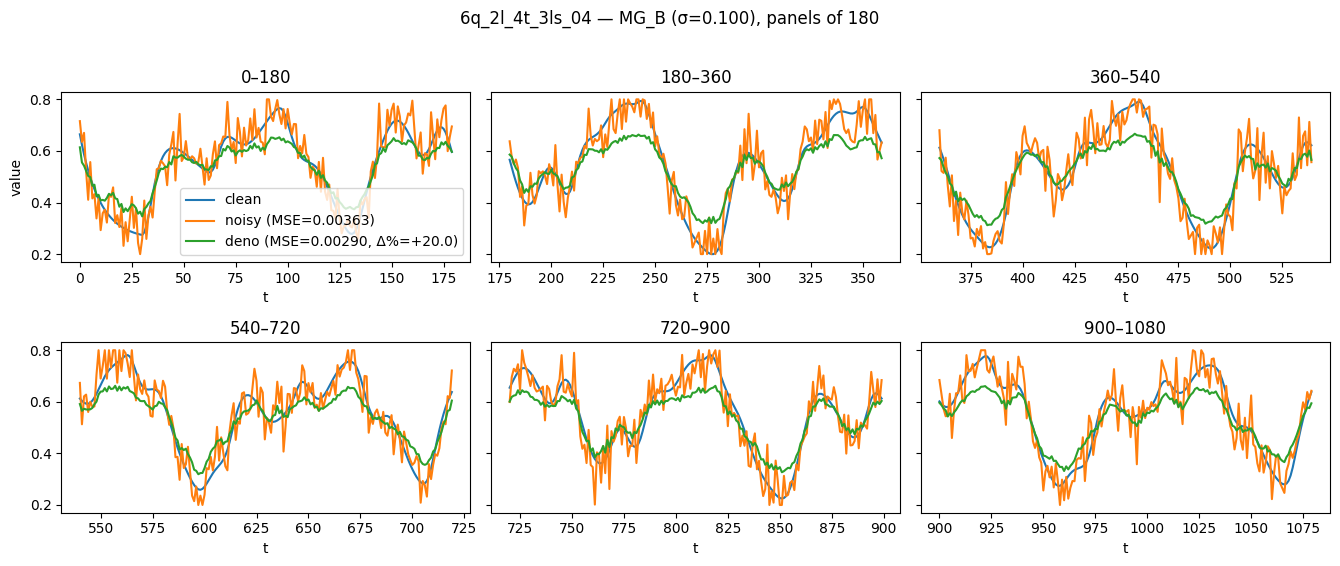

MG_B | 6q_2l_4t_3ls_04 | σ=0.100
Global MSE: noisy=0.00341 deno=0.00390 Δ%=-14.6
Samples improved: 45.5%


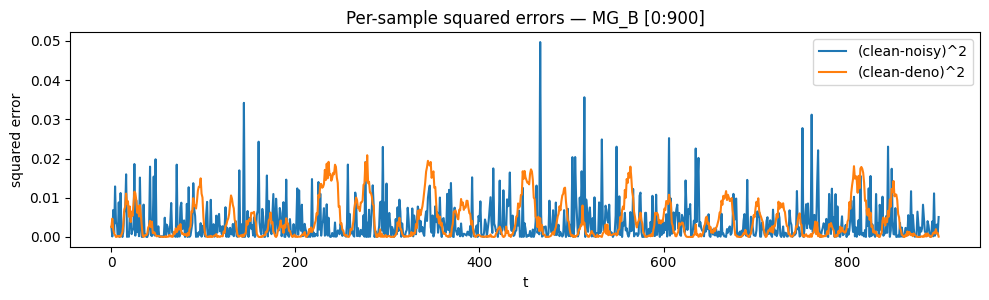

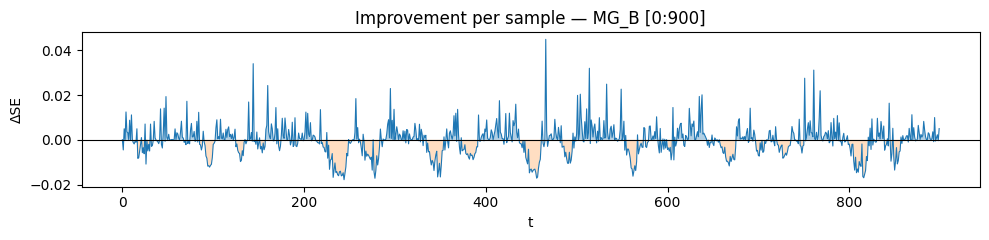

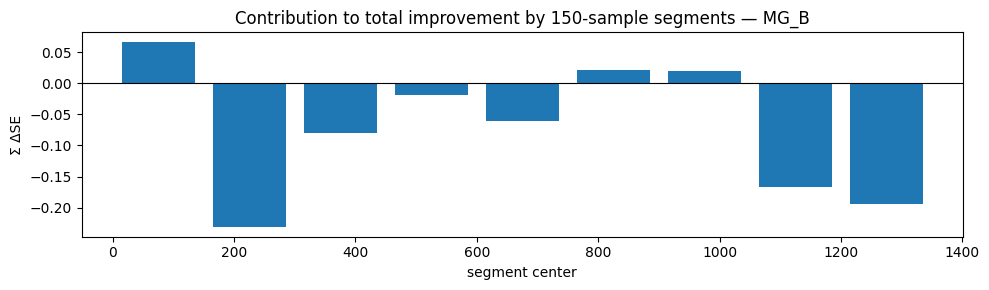

In [12]:
# === Cell 10 — Run monolith analyses & heatmaps ==============================
if REG and ALL_SUMMARIES:
    df = summaries_to_df(ALL_SUMMARIES, REG)
    print("\n== Summary (head) ==")
    print(df.head(12).to_string(index=False))

    for dsname in sorted(ALL_SUMMARIES):
        heatmap_by_arch(df, dsname, value_col="delta_pct_mean")

    # Show a few visuals per window size (first model hitting that size)
    shown=set()
    for name, entry in REG.items():
        w = entry.n_qubits
        if w in shown: continue
        dsname = "MG_A"
        er = ALL_RESULTS[dsname][name]
        plot_reconstruction_example(er, idx=0, title=f"{name} — {dsname} (σ={EVAL_SIGMA})")
        plot_robustness(entry, DATASETS_BY_W[w][dsname], sigmas=(EVAL_SIGMA,), n_eval=N_EVAL_WINDOWS)
        # Full series & panels on MG_B
        rec = reconstruct_full_series(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA)
        plot_full_series(rec, title=f"{name} — MG_B (σ={rec['sigma']:.3f})")
        plot_full_series_panels(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA,
                                panel_len=180, ncols=3, nrows=2, start=0, sharey=True)
        error_lens(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA, seg=150, start=0, length=900)
        shown.add(w)

In [13]:
# === Cell 10 — Representatives & MG_A vs MG_B scatter (monolith, robust) ====
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expect df_all from your CSVs earlier in the cell; if not present, bail out.
if "df_all" not in globals():
    print("[Cell 10] df_all not found — skipping representatives & scatter.")
else:
    df_all = df_all.copy()

    # ---- A) Ensure architecture columns exist (infer from filename if needed)
    _STD_RE = re.compile(r"(?P<nq>\d+)q_(?P<nl>\d+)l_(?P<nt>\d+)t_(?P<L>\d+)ls(?:_[0-9]+)?\.json$", re.IGNORECASE)

    def _infer_arch_from_filename(df, col="filename"):
        if col not in df.columns:
            return df
        # extract parts; this yields columns nq, nl, nt, L when pattern matches
        ext = df[col].astype(str).str.extract(_STD_RE)
        for src, dst in [("nq", "n_qubits"), ("nl", "n_latent"), ("nt", "n_trash"), ("L", "n_layers")]:
            if dst not in df.columns or df[dst].isna().all():
                if src in ext:
                    df[dst] = df.get(dst, pd.Series(index=df.index, dtype="float64"))
                    df.loc[ext[src].notna(), dst] = pd.to_numeric(ext[src], errors="coerce")
        return df

    df_all = _infer_arch_from_filename(df_all, col="filename")

    # coerce to Int64 safely (keeps NaN)
    for c in ["n_qubits", "n_latent", "n_trash", "n_layers"]:
        if c in df_all.columns:
            df_all[c] = pd.to_numeric(df_all[c], errors="coerce").astype("Int64")

    # ---- B) Build config_name without apply (avoid your ValueError)
    need = {"n_qubits", "n_latent", "n_trash", "n_layers"}
    if not need.issubset(df_all.columns):
        missing = sorted(need - set(df_all.columns))
        print(f"[Cell 10] Missing columns {missing}; cannot form config_name. Skipping.")
    else:
        # Fill any remaining NaNs with -1 markers so the string comp works
        tmp = df_all[["n_qubits","n_latent","n_trash","n_layers"]].copy()
        tmp = tmp.fillna(-1).astype(int)
        df_all["config_name"] = (
            tmp["n_qubits"].astype(str) + "q_" +
            tmp["n_latent"].astype(str) + "l_" +
            tmp["n_trash"].astype(str)  + "t_" +
            tmp["n_layers"].astype(str) + "ls"
        )

        # ---- C) Compute AVGs if not present
        if {"delta_pct_mean_MG_A","delta_pct_mean_MG_B"} <= set(df_all.columns) and "delta_pct_mean_AVG" not in df_all.columns:
            df_all["delta_pct_mean_AVG"] = pd.to_numeric(df_all["delta_pct_mean_MG_A"], errors="coerce") \
                                         .combine(pd.to_numeric(df_all["delta_pct_mean_MG_B"], errors="coerce"),
                                                  func=lambda a,b: np.nanmean([a,b], axis=0))
        if {"success_rate_pct_MG_A","success_rate_pct_MG_B"} <= set(df_all.columns) and "success_rate_pct_AVG" not in df_all.columns:
            df_all["success_rate_pct_AVG"] = pd.to_numeric(df_all["success_rate_pct_MG_A"], errors="coerce") \
                                            .combine(pd.to_numeric(df_all["success_rate_pct_MG_B"], errors="coerce"),
                                                     func=lambda a,b: np.nanmean([a,b], axis=0))
        if "sign_test_p_AVG" not in df_all.columns:
            df_all["sign_test_p_AVG"] = pd.NA  # leave blank; combining p-values properly is separate

        # ---- D) Pick “middle” representative per config
        perf_col = "delta_pct_mean_AVG"
        p_col    = "sign_test_p_AVG"
        succ_col = "success_rate_pct_AVG"

        middle_rows = []
        if perf_col in df_all.columns:
            for cfg, g in df_all.groupby("config_name", dropna=False):
                g2 = g.dropna(subset=[perf_col]).copy()
                if g2.empty:
                    continue
                med = g2[perf_col].median()
                g2["_dist"] = (g2[perf_col] - med).abs()
                if succ_col in g2.columns:
                    g2["_succ_dist"] = (pd.to_numeric(g2[succ_col], errors="coerce") - 
                                        pd.to_numeric(g2[succ_col], errors="coerce").median()).abs()
                sort_cols, ascending = ["_dist"], [True]
                if p_col in g2.columns and p_col in g2:
                    sort_cols.append(p_col); ascending.append(True)
                if "_succ_dist" in g2.columns:
                    sort_cols.append("_succ_dist"); ascending.append(True)
                sort_cols.append("filename" if "filename" in g2.columns else g2.columns[0]); ascending.append(True)
                pick = g2.sort_values(sort_cols, ascending=ascending).iloc[0]
                middle_rows.append(pick.drop(labels=[c for c in ["_dist","_succ_dist"] if c in g2.columns]))
        middle_df = pd.DataFrame(middle_rows).reset_index(drop=True)

        # ---- E) Save representatives near your project root (jacobs_examples/)
        out_dir = Path("jacobs_examples") if Path("jacobs_examples").exists() else Path(".")
        out_dir.mkdir(parents=True, exist_ok=True)
        OUT_CSV = out_dir / "representative_middle_models_with_eval.csv"
        if not middle_df.empty:
            middle_df.to_csv(OUT_CSV, index=False)
            print(f"\nSaved {len(middle_df)} representatives → {OUT_CSV}")
        else:
            print("\nNo representatives selected (insufficient eval columns or empty df).")

        # ---- F) Scatter: MG_A vs MG_B (all points + representatives if any)
        if {"delta_pct_mean_MG_A","delta_pct_mean_MG_B"} <= set(df_all.columns):
            x = pd.to_numeric(df_all["delta_pct_mean_MG_A"], errors="coerce").values
            y = pd.to_numeric(df_all["delta_pct_mean_MG_B"], errors="coerce").values

            plt.figure(figsize=(6.8, 5.2))
            plt.scatter(x, y, alpha=0.55, label="All models")

            finite = np.isfinite(x) & np.isfinite(y)
            if finite.any():
                xmin = float(np.min(np.concatenate([x[finite], y[finite]])))
                xmax = float(np.max(np.concatenate([x[finite], y[finite]])))
                plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1.0, label="y = x")

            plt.xlabel("Δ% mean on MG_A")
            plt.ylabel("Δ% mean on MG_B")
            plt.title("Model performance: MG_A vs MG_B")

            if not middle_df.empty and {"delta_pct_mean_MG_A","delta_pct_mean_MG_B"} <= set(middle_df.columns):
                xr = pd.to_numeric(middle_df["delta_pct_mean_MG_A"], errors="coerce").values
                yr = pd.to_numeric(middle_df["delta_pct_mean_MG_B"], errors="coerce").values
                plt.scatter(xr, yr, s=80, marker="D", label="Representatives")
                if "config_name" in middle_df.columns:
                    for _, r in middle_df.dropna(subset=["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]).iterrows():
                        plt.annotate(str(r["config_name"]),
                                     (float(r["delta_pct_mean_MG_A"]), float(r["delta_pct_mean_MG_B"])),
                                     xytext=(4, 4), textcoords="offset points", fontsize=8)

            plt.legend(loc="best")
            plt.tight_layout()
            plt.show()

            # Numeric summary
            def _safe_corr(a, b):
                a = np.asarray(a, float); b = np.asarray(b, float)
                m = np.isfinite(a) & np.isfinite(b)
                return np.corrcoef(a[m], b[m])[0,1] if m.sum() >= 3 else np.nan

            corr_all = _safe_corr(x, y)
            above = int(np.nansum(y > x))
            below = int(np.nansum(y < x))
            equal = int(np.nansum(np.isclose(y, x, atol=1e-9)))
            print(f"Correlation (Δ% MG_A vs MG_B, all models): r = {corr_all:.3f}")
            print(f"Points above diagonal (MG_B > MG_A): {above}")
            print(f"Points below diagonal (MG_B < MG_A): {below}")
            print(f"On diagonal: {equal}")

            # Per-config comparison table (representatives if available, else medians)
            if not middle_df.empty and {"config_name","delta_pct_mean_MG_A","delta_pct_mean_MG_B"} <= set(middle_df.columns):
                comp = (middle_df[["config_name","filename","run_tag",
                                   "delta_pct_mean_MG_A","delta_pct_mean_MG_B","delta_pct_mean_AVG"]]
                        .dropna(subset=["delta_pct_mean_MG_A","delta_pct_mean_MG_B"], how="any")
                        .sort_values("config_name", kind="stable"))
                print("\nRepresentatives — MG_A vs MG_B:")
                try:
                    display(comp)
                except Exception:
                    print(comp.to_string(index=False))
            else:
                # medians per config if we can
                if "config_name" in df_all.columns:
                    med = (df_all.groupby("config_name")[["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]]
                                 .median().reset_index())
                    med["delta_pct_mean_AVG"] = med[["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]].mean(axis=1)
                    print("\nGroup medians (no representatives found in scope):")
                    try:
                        display(med.sort_values("config_name"))
                    except Exception:
                        print(med.sort_values("config_name").to_string(index=False))
        else:
            print("[Cell 10] Missing Δ% columns (delta_pct_mean_MG_A / MG_B) — skipping scatter.")

[Cell 10] df_all not found — skipping representatives & scatter.


In [14]:
!pip list | grep -E 'PennyLane|torch|jax'

jax                       0.4.28
jax-cuda12-pjrt           0.4.28
jax-cuda12-plugin         0.4.28
jaxlib                    0.4.28
PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
